In [1]:
import tensorrt
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

2023-06-29 21:35:21.010432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Convolutional layers and their shapes

2023-06-27 14:39:13.820046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 14:39:13.930347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 14:39:13.930401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 14:39:13.933050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 14:39:13.933087: I tensorflow/compile

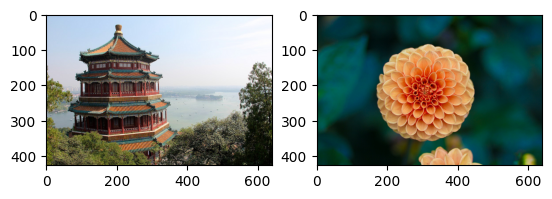

In [4]:
images = tf.constant(load_sample_images()['images'])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(images[0])
ax2.imshow(images[1])
display()

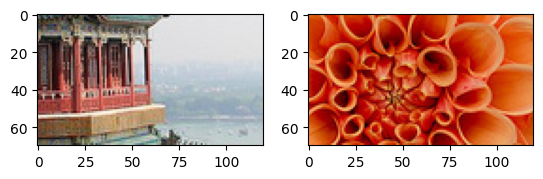

In [5]:
images2 = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images2 = tf.keras.layers.Rescaling(scale=1 / 256)(images2)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(images2[0])
ax2.imshow(images2[1])
display()

In [6]:
images2.shape

TensorShape([2, 70, 120, 3])

In [7]:
conv_layer = tf.keras.layers.Conv2D(32, kernel_size=7)
fmaps = conv_layer(images2)
fmaps.shape

2023-06-27 14:39:17.395460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-06-27 14:39:18.457650: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


TensorShape([2, 64, 114, 32])

In [8]:
conv_layer = tf.keras.layers.Conv2D(32, kernel_size=7, padding='same')
fmaps = conv_layer(images2)
fmaps.shape

TensorShape([2, 70, 120, 32])

In [9]:
conv_layer = tf.keras.layers.Conv2D(32, kernel_size=7, padding='same', strides=2)
fmaps = conv_layer(images2)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [10]:
kernels, biases = conv_layer.get_weights()
print(kernels.shape)
print(biases.shape)

(7, 7, 3, 32)
(32,)


# Pooling layers

(2, 427, 640, 3)
(2, 213, 320, 3)


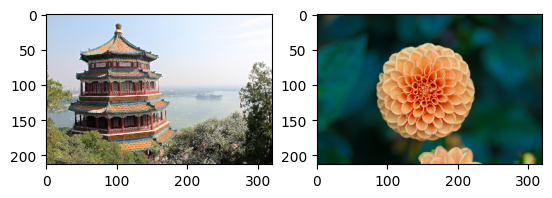

In [11]:
# By default, strides is equal to pool size if not provided
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)
images3 = max_pool(images)
print(images.shape)
print(images3.shape)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(images3[0])
ax2.imshow(images3[1])
display()

## Implementing a max pooling layer that works on the depth dimension

In [79]:
class DepthMaxPooling(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    # input ~ (batch, height, width, input_channels)
    # output ~ (batch, height, width, input_channels / pool size)
    def my_call(self, input):
        tensor = None
        for d in tf.range(input.shape[-1] // self.pool_size):
            new_layer = tf.reduce_max(input[..., d * self.pool_size: (d + 1) * self.pool_size], axis=-1, keepdims=True)
            tensor = tf.concat([x for x in [tensor, new_layer] if x is not None], axis=-1)
        return tensor

    # This neat method "breaks down" the last axis to the number of groups.
    # However, it only works if the number of groups x pool size equals the depth exactly
    def book_call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

    def fixed_book_call(self, inputs):
        trailing_zeros = (self.pool_size - inputs.shape[-1] % self.pool_size) % self.pool_size
        paddings = tf.constant([[0, 0], [0, 0], [0, 0], [0, trailing_zeros]])
        inputs = tf.pad(inputs, paddings)
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

    def call(self, inputs):
        return self.fixed_book_call(inputs)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'pool_size': self.pool_size}

In [90]:
# shape=(3, 2, 2, 4)
test_input = tf.constant(
    [[[[1., 2., 3., 4., 9.],
       [5., 6., 7., 8., 9.]],

      [[9., 10., 11., 12., 9.],
       [13., 14., 15., 16., 9.]]],

     [[[10., 20., 30., 40., 9.],
       [50., 60., 70., 80., 9.]],

      [[90., 100., 110., 120., 9.],
       [130., 140., 150., 160, 9.]]],

     [[[100., 200., 300., 400., 9.],
       [500., 600., 700., 800., 9.]],

      [[900., 1000., 1100., 1200., 9.],
       [1300., 1400., 1500., 1600., 9.]]]], dtype=tf.float32
)

# shape = tf.shape(test_input)
# print(shape)
# groups = shape[-1] // 2
# print(groups)
# new_shape = tf.concat([shape[:-1], [groups, 2]], axis=0)
# print(new_shape)
# tf.reshape(test_input, new_shape)

# pool_size = 2
# trailing_zeros = (pool_size - test_input.shape[-1] % pool_size) % pool_size
# paddings = tf.constant([[0, 0], [0, 0], [0, 0], [0, trailing_zeros]])
# test_input = tf.pad(test_input, paddings)

dmp = DepthMaxPooling(pool_size=2)
dmp(test_input)
# a = tf.reduce_max(test_input[..., 0:2], axis=-1, keepdims=True)
# b = tf.reduce_max(test_input[..., 2:4], axis=-1, keepdims=True)
# tf.concat([a], axis=-1)

<tf.Tensor: shape=(3, 2, 2, 3), dtype=float32, numpy=
array([[[[   2.,    4.,    9.],
         [   6.,    8.,    9.]],

        [[  10.,   12.,    9.],
         [  14.,   16.,    9.]]],


       [[[  20.,   40.,    9.],
         [  60.,   80.,    9.]],

        [[ 100.,  120.,    9.],
         [ 140.,  160.,    9.]]],


       [[[ 200.,  400.,    9.],
         [ 600.,  800.,    9.]],

        [[1000., 1200.,    9.],
         [1400., 1600.,    9.]]]], dtype=float32)>

# Models

## Model 1

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

train = tf.data.Dataset.from_tensor_slices((x_train[6000:], y_train[6000:])).shuffle(10000).batch(32).prefetch(1)
valid = tf.data.Dataset.from_tensor_slices((x_train[:6000], y_train[:6000])).batch(32).prefetch(1)
test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(1)

In [12]:
from functools import partial

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape(target_shape=(28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Rescaling(scale=1 / 256),
    DefaultConv2D(filters=64, kernel_size=7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

In [11]:
from pathlib import Path

model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Nadam(),
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)

root_dir = Path('data/02-fashion-mnist')
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint(root_dir / 'model', save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_dir / 'tensorboard')

hist = model.fit(
    train,
    epochs=100,
    validation_data=valid,
    callbacks=[early_stop_cb, checkpoints_cb, tensorboard_cb]
)

ValueError: in user code:

    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "conv2d_10" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 28, 28)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 28, 28), dtype=uint8)
      • training=True
      • mask=None


In [8]:
model.evaluate(test)

 11/313 [>.............................] - ETA: 5s - loss: 0.2935 - sparse_categorical_accuracy: 0.9233

2023-06-27 17:09:30.720096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [10000]
	 [[{{node Placeholder/_1}}]]


313/313 [==============================] - 2s 5ms/step - loss: 0.2710 - sparse_categorical_accuracy: 0.9128


[0.27101919054985046, 0.9128000140190125]

# ResNet-34 made by hand

In [2]:
from functools import partial

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    strides=1,
    padding='same',
    kernel_initializer='he_normal',
    use_bias=False
)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters=filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters=filters),
            tf.keras.layers.BatchNormalization(),
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters=filters, strides=strides, kernel_size=1),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        z = inputs
        for layer in self.main_layers:
            z = layer(z)
        skip_z = inputs
        for layer in self.skip_layers:
            skip_z = layer(skip_z)
        return self.activation(z + skip_z)

In [3]:
model = tf.keras.Sequential([
    # I added to accept CIFAR-100:
    tf.keras.layers.Rescaling(scale=1/256, input_shape=[32, 32, 3]),
    DefaultConv2D(filters=64, kernel_size=7, strides=2),
    # Original:
    # DefaultConv2D(filters=64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
# Note: the original has 1000 classes, not 100. I changed this for CIFAR-100
model.add(tf.keras.layers.Dense(100, activation='softmax'))

2023-06-29 21:35:24.716261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-29 21:35:24.849581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-29 21:35:24.849622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-29 21:35:24.851591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-29 21:35:24.851625: I tensorflow/compile

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
print(x_train.shape)
print(x_test.shape)
train = tf.data.Dataset.from_tensor_slices((x_train[5000:], y_train[5000:])).shuffle(10000).batch(32).prefetch(1)
valid = tf.data.Dataset.from_tensor_slices((x_train[:5000], y_train[:5000])).batch(32).prefetch(1)
test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(1)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


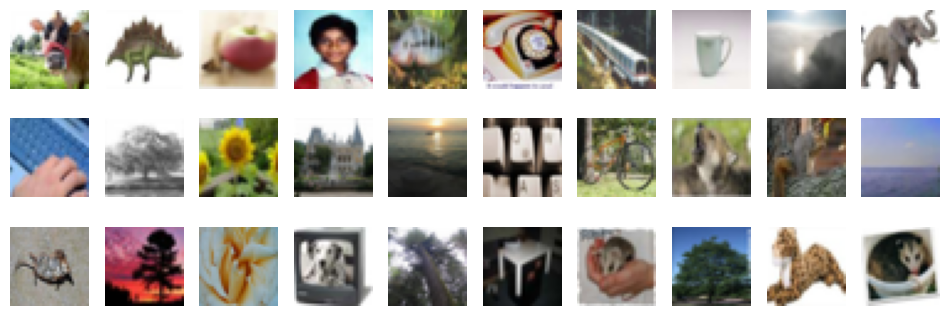

In [26]:
n_rows = 3
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4))
for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        img = x_train[row * n_cols + col]
        ax.imshow(img)
        ax.set_axis_off()

In [7]:
root_dir = Path() / 'data/04-cifar-100'
checkpoints_dir = root_dir / 'checkpoints'
tensorboard_dir = root_dir / 'tensorboard'
tensorboard_cb = tf.keras.callbacks.TensorBoard(tensorboard_dir)
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint(checkpoints_dir, save_best_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

if checkpoints_dir.exists():
    model.load_weights(checkpoints_dir)

model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)

hist = model.fit(
    train,
    validation_data=valid,
    callbacks=[tensorboard_cb, checkpoints_cb, early_stop_cb],
    epochs=100
)

2023-06-29 21:37:18.182700: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open data/04-cifar-100/checkpoints: FAILED_PRECONDITION: data/04-cifar-100/checkpoints; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


Epoch 1/100


2023-06-29 21:37:18.693572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [45000,32,32,3]
	 [[{{node Placeholder/_0}}]]
2023-06-29 21:37:18.693805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [45000,32,32,3]
	 [[{{node Placeholder/_0}}]]
2023-06-29 21:37:28.387031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-06-29 21:37:30.085529: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-29 21:37:33.028823: I tensorf

1407/1407 [==============================] - ETA: 0s - loss: 0.9731 - sparse_categorical_accuracy: 0.7070

2023-06-29 21:38:59.218281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5000,1]
	 [[{{node Placeholder/_1}}]]


INFO:tensorflow:Assets written to: data/04-cifar-100/checkpoints/assets


INFO:tensorflow:Assets written to: data/04-cifar-100/checkpoints/assets


1407/1407 [==============================] - 114s 62ms/step - loss: 0.9731 - sparse_categorical_accuracy: 0.7070 - val_loss: 2.9512 - val_sparse_categorical_accuracy: 0.3848
Epoch 2/100
1407/1407 [==============================] - 72s 51ms/step - loss: 0.7880 - sparse_categorical_accuracy: 0.7564 - val_loss: 3.3979 - val_sparse_categorical_accuracy: 0.3642
Epoch 3/100
1407/1407 [==============================] - 72s 51ms/step - loss: 0.6455 - sparse_categorical_accuracy: 0.7978 - val_loss: 3.5561 - val_sparse_categorical_accuracy: 0.3480
Epoch 4/100
1407/1407 [==============================] - 74s 52ms/step - loss: 0.5311 - sparse_categorical_accuracy: 0.8304 - val_loss: 3.4313 - val_sparse_categorical_accuracy: 0.3846
Epoch 5/100
1407/1407 [==============================] - 73s 52ms/step - loss: 0.4574 - sparse_categorical_accuracy: 0.8536 - val_loss: 3.4736 - val_sparse_categorical_accuracy: 0.3904
Epoch 6/100
1407/1407 [==============================] - 72s 51ms/step - loss: 0.3976 

# Pretrained ResNet-50

In [8]:
model = tf.keras.applications.ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 4s 0us/step


In [14]:
images = load_sample_images()['images']
images_resized = tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True)(images)
print(len(images))
print(images[0].shape)
print(images_resized.shape)

2
(427, 640, 3)
(2, 224, 224, 3)


In [16]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)
y_proba = model.predict(inputs)
y_proba.shape

1/1 [==============================] - 2s 2s/step


(2, 1000)

In [23]:
top_k = tf.keras.applications.resnet50.decode_predictions(y_proba, top=3)
for image_index in range(len(images)):
    print(f"image {image_index}")
    for class_id, name, y_proba in top_k[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")


image 0
  n03877845 - palace       54.77%
  n03781244 - monastery    24.69%
  n02825657 - bell_cote    18.50%
image 1
  n04522168 - vase         32.73%
  n11939491 - daisy        17.81%
  n03530642 - honeycomb    12.05%


# Transfer learning

In [26]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

In [43]:
print(info.splits['train'].num_examples)
print(info.features['label'].names)
print(info.features['label'].num_classes)

3670
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5


In [45]:
test_raw, valid_raw, train_raw = tfds.load(
    'tf_flowers',
    split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    as_supervised=True
)

In [46]:
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train = train_raw.map(lambda x, y: (preprocess(x), y)).shuffle(10000).batch(batch_size).prefetch(1)
valid = valid_raw.map(lambda x, y: (preprocess(x), y)).batch(batch_size)
test = test_raw.map(lambda x, y: (preprocess(x), y)).batch(batch_size)

In [47]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomRotation(factor=0.05),
    tf.keras.layers.RandomContrast(factor=0.2)
])

In [48]:
base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = tf.keras.layers.GlobalAvgPool2D()(base_model.output)
output = tf.keras.layers.Dense(5, activation='softmax')(avg)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 4s 0us/step


In [49]:
for layer in base_model.layers:
    layer.trainable = False

In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)
history = model.fit(
    train,
    validation_data=valid,
    epochs = 3
)

Epoch 1/3


2023-06-30 10:41:56.990031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [2]
	 [[{{node Placeholder/_4}}]]
2023-06-30 10:41:56.990482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]
2023-06-30 10:42:09.336935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2101 of 10000
2023-06-30 10:42:11.990580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


86/86 [==============================] - ETA: 0s - loss: 0.8707 - sparse_categorical_accuracy: 0.8012

2023-06-30 10:42:24.629600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-06-30 10:42:24.629911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


86/86 [==============================] - 34s 195ms/step - loss: 0.8707 - sparse_categorical_accuracy: 0.8012 - val_loss: 1.1117 - val_sparse_categorical_accuracy: 0.7931
Epoch 2/3
86/86 [==============================] - 20s 156ms/step - loss: 0.5306 - sparse_categorical_accuracy: 0.8903 - val_loss: 0.6178 - val_sparse_categorical_accuracy: 0.8693
Epoch 3/3
86/86 [==============================] - 14s 149ms/step - loss: 0.2572 - sparse_categorical_accuracy: 0.9350 - val_loss: 0.8349 - val_sparse_categorical_accuracy: 0.8439


In [53]:
for index, layer in enumerate(base_model.layers):
    print(f"  {index}: {layer.name}")

  0: input_2
  1: block1_conv1
  2: block1_conv1_bn
  3: block1_conv1_act
  4: block1_conv2
  5: block1_conv2_bn
  6: block1_conv2_act
  7: block2_sepconv1
  8: block2_sepconv1_bn
  9: block2_sepconv2_act
  10: block2_sepconv2
  11: block2_sepconv2_bn
  12: conv2d_36
  13: block2_pool
  14: batch_normalization_36
  15: add
  16: block3_sepconv1_act
  17: block3_sepconv1
  18: block3_sepconv1_bn
  19: block3_sepconv2_act
  20: block3_sepconv2
  21: block3_sepconv2_bn
  22: conv2d_37
  23: block3_pool
  24: batch_normalization_37
  25: add_1
  26: block4_sepconv1_act
  27: block4_sepconv1
  28: block4_sepconv1_bn
  29: block4_sepconv2_act
  30: block4_sepconv2
  31: block4_sepconv2_bn
  32: conv2d_38
  33: block4_pool
  34: batch_normalization_38
  35: add_2
  36: block5_sepconv1_act
  37: block5_sepconv1
  38: block5_sepconv1_bn
  39: block5_sepconv2_act
  40: block5_sepconv2
  41: block5_sepconv2_bn
  42: block5_sepconv3_act
  43: block5_sepconv3
  44: block5_sepconv3_bn
  45: add_3
  

In [54]:
# Residual unit 7+
for layer in base_model.layers[56:]:
    layer.trainable = True

# Changing the learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# Must re-compile everytime we freeze / unfreeze layers
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)
history = model.fit(
    train,
    validation_data=valid,
    epochs = 10
)

Epoch 1/10
86/86 [==============================] - 37s 258ms/step - loss: 0.3016 - sparse_categorical_accuracy: 0.9015 - val_loss: 0.7523 - val_sparse_categorical_accuracy: 0.8385
Epoch 2/10
86/86 [==============================] - 26s 252ms/step - loss: 0.0372 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.5478 - val_sparse_categorical_accuracy: 0.8838
Epoch 3/10
86/86 [==============================] - 24s 247ms/step - loss: 0.0192 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.3737 - val_sparse_categorical_accuracy: 0.9020
Epoch 4/10
86/86 [==============================] - 22s 237ms/step - loss: 0.0076 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.3488 - val_sparse_categorical_accuracy: 0.9165
Epoch 5/10
86/86 [==============================] - 22s 244ms/step - loss: 0.0055 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.3327 - val_sparse_categorical_accuracy: 0.9201
Epoch 6/10
86/86 [==============================] - 22s 242ms/step - loss: 0.0049 - sparse_cate

In [55]:
model.evaluate(test)

2023-06-30 10:58:01.046991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-06-30 10:58:01.048796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


12/12 [==============================] - 3s 192ms/step - loss: 0.3272 - sparse_categorical_accuracy: 0.9210


[0.32720690965652466, 0.9209809303283691]